In [1]:
import numpy as np
from brian2.only import *
import deepdish as dd

from readout import load_results
import spatial

import conf.isi5_500 as cfg

In [2]:
conds = ('dev', 'msc', 'std')
K = 1.4

In [3]:
def get_bspikes(res, episode):
    b = np.zeros(np.asarray(res['raw_dynamics']['v'].shape)[[0,2,3]], bool)
    for itrial, (i, spike_t) in enumerate(zip(*[res['raw_spikes'][episode][f'pulsed_{k}'] for k in 'it'])):
        t = (spike_t / cfg.params['dt'] + .5).astype(int)
        b[i, itrial, t] = True
    return b

In [4]:
def get_neuron_distances(netf, stim):
    x,y = [xy[cfg.stimuli[stim]] for xy in spatial.create_stimulus_locations(cfg.params)]
    return np.sqrt((netf['X']*meter-x)**2 + (netf['Y']*meter-y)**2)

In [5]:
def get_trial_average(res, episode, stim_distances, stimidx=None):
    spike_distances, spike_counts, target = np.empty((3, len(res['sequences'][episode])))
    target = target.astype(bool)
    spikes = get_bspikes(res, episode)
    for trial, idx_stimulated in enumerate(res['sequences'][episode]):
        dist_from_stimulated = stim_distances[idx_stimulated]
        trial_spikes = spikes[:, trial]
        trial_distances = np.broadcast_to(dist_from_stimulated[:, None], trial_spikes.shape)[trial_spikes]
        spike_distances[trial] = np.median(trial_distances)
        target[trial] = idx_stimulated == stimidx
        spike_counts[trial] = trial_spikes.sum()
    return spike_distances, spike_counts, target

In [6]:
maxdist = cfg.params['r_dish'] + cfg.params['stim_distribution_radius']
distbins = 200
histargs = {'bins': distbins, 'range': (0, maxdist/mm)}
_, histedges = np.histogram([0], **histargs)
distbins_rough = 2
# histargs_rough = {'bins': [0, 0.6, maxdist/mm]}
histargs_rough = {'bins': [0, 2, maxdist/mm]}
_, histedges_rough = np.histogram([0], **histargs_rough)

def get_trial_hist(res, episode, stim_distances):
    spikes = get_bspikes(res, episode)
    hist = np.empty((len(res['sequences'][episode]), distbins))
    hist_norm = {i: np.histogram(stim_distances[i]/mm, **histargs)[0] for i in np.unique(res['sequences'][episode])}
    rough = np.empty((len(res['sequences'][episode]), distbins_rough))
    rough_norm = {i: np.histogram(stim_distances[i]/mm, **histargs_rough)[0] for i in np.unique(res['sequences'][episode])}
    for trial, idx_stimulated in enumerate(res['sequences'][episode]):
        dist_from_stimulated = stim_distances[idx_stimulated]
        trial_spikes = spikes[:, trial]
        trial_distances = np.broadcast_to(dist_from_stimulated[:, None], trial_spikes.shape)[trial_spikes]
        trial_hist, edges = np.histogram(trial_distances/mm, **histargs)
        trial_rough, edges = np.histogram(trial_distances/mm, **histargs_rough)
        hist[trial] = trial_hist / hist_norm[idx_stimulated]
        rough[trial] = trial_rough / rough_norm[idx_stimulated]
    return hist, rough

def get_hist_base(res, stim_distances, stimid):
    hist, edges = np.histogram(stim_distances[stimid]/mm, **histargs)
    rough, edges = np.histogram(stim_distances[stimid]/mm, **histargs_rough)
    return hist, rough

In [7]:
def get_average_responses(res):
    R = {}
    allspikes = [get_bspikes(res, episode) for episode in range(len(res['sequences']))]
    for ipair, pair in enumerate(cfg.pairings):
        for istim, stim in enumerate(pair):
            stimidx = cfg.stimuli[stim]
            r = []
            for cond in conds:
                episode = res['pairs'][ipair][cond][stim]
                trials = res['sequences'][episode] == stimidx
                r.append(allspikes[episode][:, trials].sum(2).mean(1))
            R[stimidx] = np.mean(r, 0)
    return R

In [8]:
def get_distribution_indices(stim_distances, stim_indices):
    fine_binned_distances, rough_binned_distances = {}, {}
    fine_norm, rough_norm = {}, {}
    for idx in np.unique(stim_indices):
        dist = stim_distances[idx] / mm
        fine_binned_distances[idx] = np.digitize(dist, histedges) - 1
        rough_binned_distances[idx] = np.digitize(dist, histedges_rough) - 1
        fine_norm[idx], _ = np.histogram(dist, **histargs)
        rough_norm[idx], _ = np.histogram(dist, **histargs_rough)
    return fine_binned_distances, fine_norm, rough_binned_distances, rough_norm

In [9]:
def get_TA_distrib(res, episode, stim_distances):
    fine_TA = np.zeros((len(res['sequences'][episode]), distbins))
    rough_TA = np.zeros((len(res['sequences'][episode]), distbins_rough))
    fine_binned_distances, fine_norm, rough_binned_distances, rough_norm = get_distribution_indices(
        stim_distances, np.unique(res['sequences'][episode]))
    for trial, idx_stimulated in enumerate(res['sequences'][episode]):
        np.add.at(
            fine_TA[trial], fine_binned_distances[idx_stimulated],
            res['raw_dynamics']['th_adapt'][:, episode, trial, 0])
        fine_TA[trial] /= fine_norm[idx_stimulated]
        np.add.at(
            rough_TA[trial], rough_binned_distances[idx_stimulated],
            res['raw_dynamics']['th_adapt'][:, episode, trial, 0])
        rough_TA[trial] /= rough_norm[idx_stimulated]
    return fine_TA, rough_TA

In [10]:
def get_STD_distrib(res, episode, stim_distances, R, Wb):
    fine_STD = np.zeros((len(res['sequences'][episode]), distbins))
    rough_STD = np.zeros((len(res['sequences'][episode]), distbins_rough))
    fine_binned_distances, fine_norm, rough_binned_distances, rough_norm = get_distribution_indices(
        stim_distances, np.unique(res['sequences'][episode]))
    for trial, idx_stimulated in enumerate(res['sequences'][episode]):
        if idx_stimulated not in R:
            continue
        xr = res['raw_dynamics']['neuron_xr'][:, episode, trial, 0]
        D = np.einsum('eo,e->o', Wb, R[idx_stimulated] * (1-xr)) * K
        np.add.at(fine_STD[trial], fine_binned_distances[idx_stimulated], D)
        fine_STD[trial] /= fine_norm[idx_stimulated]
        np.add.at(rough_STD[trial], rough_binned_distances[idx_stimulated], D)
        rough_STD[trial] /= rough_norm[idx_stimulated]
    return fine_STD, rough_STD

In [11]:
isi, TA, STD, templ = 500, 1, 1, 0
distances, counts = [{cond: np.full((cfg.N_networks*len(cfg.pairings)*2, cfg.params['sequence_length']*cfg.params['sequence_count']), np.nan)
                               for cond in conds} for _ in range(2)]
disthist = {cond: np.full((cfg.N_networks*len(cfg.pairings)*2, cfg.params['sequence_length']*cfg.params['sequence_count'], distbins), np.nan)
            for cond in conds}
distrough = {cond: np.full((cfg.N_networks*len(cfg.pairings)*2, cfg.params['sequence_length']*cfg.params['sequence_count'], distbins_rough), np.nan)
            for cond in conds}
histbase = np.zeros((cfg.N_networks*len(cfg.pairings)*2, distbins))
roughbase = np.zeros((cfg.N_networks*len(cfg.pairings)*2, distbins_rough))

fine_TA, fine_STD = [
    {cond: np.full((cfg.N_networks*len(cfg.pairings)*2, cfg.params['sequence_length']*cfg.params['sequence_count'], distbins), np.nan)
     for cond in conds} for _ in 'ab']
rough_TA, rough_STD = [
    {cond: np.full((cfg.N_networks*len(cfg.pairings)*2, cfg.params['sequence_length']*cfg.params['sequence_count'], distbins_rough), np.nan)
     for cond in conds} for _ in 'ab']

for net in range(cfg.N_networks):
    res = load_results(
        cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ),
        dynamics_supplements={'neuron_xr': 1},
        process_spikes=False, process_dynamics=False)
    netf = dd.io.load(cfg.netfile.format(net=net))
    stim_distances = {iX: get_neuron_distances(netf, X) for X, iX in cfg.stimuli.items()}
    Wb = netf['W'] > 0
    R = get_average_responses(res)

    # msc
    msc_dist, msc_count, _ = get_trial_average(res, 0, stim_distances)
    msc_hist, msc_rough = get_trial_hist(res, 0, stim_distances)
    msc_fine_TA, msc_rough_TA = get_TA_distrib(res, 0, stim_distances)
    msc_fine_STD, msc_rough_STD = get_STD_distrib(res, 0, stim_distances, R, Wb)

    for ipair, pair in enumerate(cfg.pairings):
        for istim, stim in enumerate(pair):
            episode = res['pairs'][ipair]['dev'][stim]
            dist, count, target = get_trial_average(res, episode, stim_distances, cfg.stimuli[stim])
            hist, rough = get_trial_hist(res, episode, stim_distances)
            ep_fine_TA, ep_rough_TA = get_TA_distrib(res, episode, stim_distances)
            ep_fine_STD, ep_rough_STD = get_STD_distrib(res, episode, stim_distances, R, Wb)
            i = 4*net + 2*ipair + istim

            distances['dev'][i, target] = dist[target]
            counts['dev'][i, target] = count[target]
            disthist['dev'][i, target] = hist[target]
            distrough['dev'][i, target] = rough[target]
            fine_TA['dev'][i, target] = ep_fine_TA[target]
            rough_TA['dev'][i, target] = ep_rough_TA[target]
            fine_STD['dev'][i, target] = ep_fine_STD[target]
            rough_STD['dev'][i, target] = ep_rough_STD[target]

            distances['std'][i, ~target] = dist[~target]
            counts['std'][i, ~target] = count[~target]
            disthist['std'][i, ~target] = hist[~target]
            distrough['std'][i, ~target] = rough[~target]
            fine_TA['std'][i, ~target] = ep_fine_TA[~target]
            rough_TA['std'][i, ~target] = ep_rough_TA[~target]
            fine_STD['std'][i, ~target] = ep_fine_STD[~target]
            rough_STD['std'][i, ~target] = ep_rough_STD[~target]

            msc_target = res['sequences'][0] == cfg.stimuli[stim]
            distances['msc'][i, msc_target] = msc_dist[msc_target]
            counts['msc'][i, msc_target] = msc_count[msc_target]
            disthist['msc'][i, msc_target] = msc_hist[msc_target]
            distrough['msc'][i, msc_target] = msc_rough[msc_target]
            fine_TA['msc'][i, msc_target] = msc_fine_TA[msc_target]
            rough_TA['msc'][i, msc_target] = msc_rough_TA[msc_target]
            fine_STD['msc'][i, msc_target] = msc_fine_STD[msc_target]
            rough_STD['msc'][i, msc_target] = msc_rough_STD[msc_target]

            histbase[i], roughbase[i] = get_hist_base(res, stim_distances, cfg.stimuli[stim])
    print(net, end=' ')

dd.io.save('distance.h5', {
    'distances': distances,
    'counts': counts,
    'disthist': disthist,
    'distrough': distrough,
    'histbase': histbase,
    'roughbase': roughbase,
    'fine_TA': fine_TA,
    'fine_STD': fine_STD,
    'rough_TA': rough_TA,
    'rough_STD': rough_STD
})

WARNING    /tmp/ipykernel_415252/3621769595.py:22: RuntimeWarning: invalid value encountered in true_divide
  hist[trial] = trial_hist / hist_norm[idx_stimulated]
 [py.warnings]
WARNING    /tmp/ipykernel_415252/3856939898.py:10: RuntimeWarning: invalid value encountered in true_divide
  fine_TA[trial] /= fine_norm[idx_stimulated]
 [py.warnings]
WARNING    /tmp/ipykernel_415252/606363850.py:12: RuntimeWarning: invalid value encountered in true_divide
  fine_STD[trial] /= fine_norm[idx_stimulated]
 [py.warnings]


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

In [11]:
_ = dd.io.load('distance.h5')
distances = _['distances']
counts = _['counts']
disthist = _['disthist']
distrough = _['distrough']
histbase = _['histbase']
roughbase = _['roughbase']
fine_TA = _['fine_TA']
fine_STD = _['fine_STD']
rough_TA = _['rough_TA']
rough_STD = _['rough_STD']

In [12]:
disthist_initial = np.nanmean(np.concatenate([d[:, 0] for d in disthist.values()], 0), 0)
distrough_initial = np.nanmean(np.concatenate([d[:, 0] for d in distrough.values()], 0), 0)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import plot_utils as pu
import scipy.stats as stats

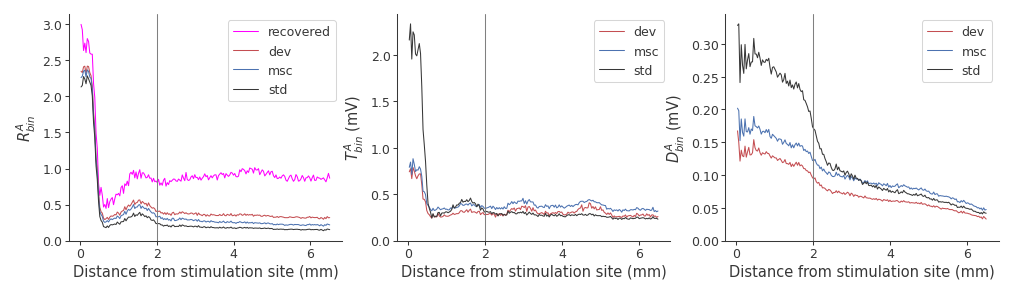

In [14]:
def panel_raw_lines(ax, kind='hist'):
    raw = {'hist': disthist, 'TA': fine_TA, 'STD': fine_STD}
    assert kind in raw
    divisor = 1
    if kind == 'hist':
        ax.plot(histedges[1:], disthist_initial, color='magenta', label='recovered')
    elif kind=='TA':
        divisor = mV
    for cond in ('dev', 'msc', 'std'):
        ax.plot(histedges[1:], np.nanmean(raw[kind][cond][:, 1:], (0,1)) / divisor, color=pu.colors[cond], label=cond)
    for edge in histedges_rough[1:-1]:
        ax.axvline(edge, color='grey')
    ax.legend()
    ax.set_xlabel('Distance from stimulation site (mm)')
    ax.set_ylabel({
        'hist': '$R^A_{bin}$',
        'TA': '$T^A_{bin}$ (mV)',
        'STD': '$D^A_{bin}$ (mV)'}
        [kind])
    ax.set_ylim(bottom=0)
    sns.despine(ax=ax)

fig, axs = plt.subplots(1, 3, figsize=(8,2), dpi=150)
for ax, kind in zip(axs, ('hist', 'TA', 'STD')):
    panel_raw_lines(ax, kind)

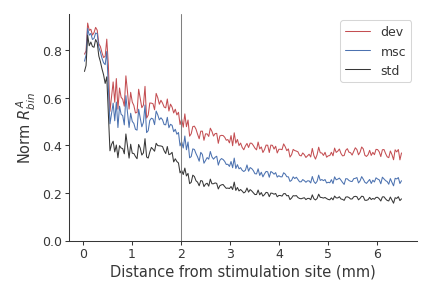

In [15]:
def panel_frac_hist_lines(ax):
    for cond in conds:
        ax.plot(histedges[1:], (np.nanmean(disthist[cond][:, 1:], (0,1)) / disthist_initial), color=pu.colors[cond], label=cond)
    for edge in histedges_rough[1:-1]:
        ax.axvline(edge, color='grey')
    ax.legend()
    ax.set_xlabel('Distance from stimulation site (mm)')
    ax.set_ylabel('Norm $R^A_{bin}$')
    ax.set_ylim(bottom=0)
    sns.despine(ax=ax)

fig, ax = plt.subplots(figsize=(3,2), dpi=150)
panel_frac_hist_lines(ax)

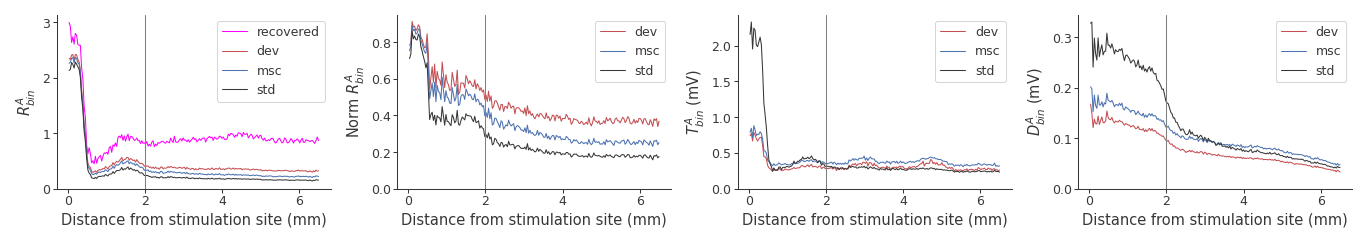

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(9,1.5), dpi=150, layout='constrained')
fig.patch.set_facecolor('w')
for ax, kind in zip(axs[[0,2,3]], ('hist', 'TA', 'STD')):
    panel_raw_lines(ax, kind)
panel_frac_hist_lines(axs[1])

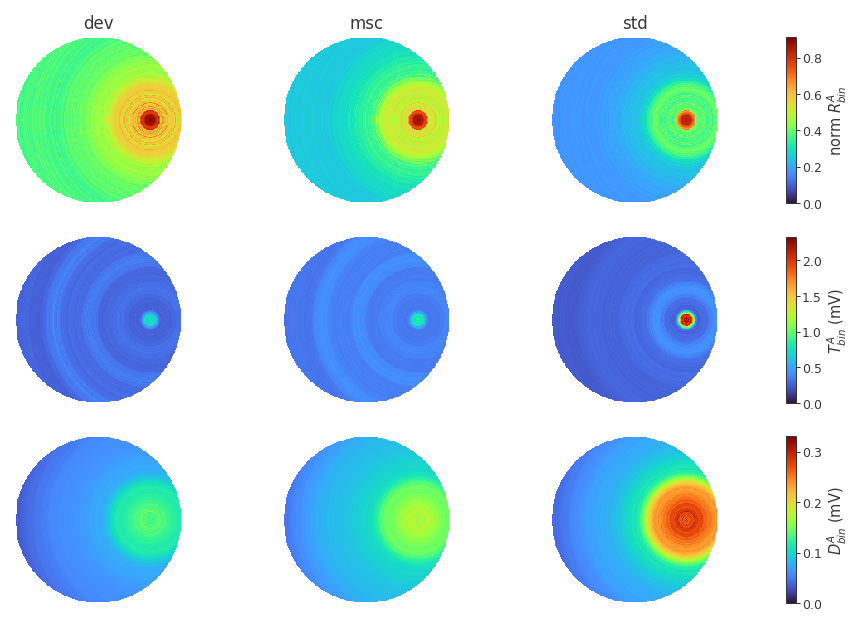

In [30]:
def panel_frac_space(axs, cax, kind='hist', **kwargs):
    raw = {'hist': disthist, 'TA': fine_TA, 'STD': fine_STD}
    assert kind in raw
    divisor = {'hist': disthist_initial, 'TA': mV, 'STD': 1}[kind]
    sz = 100
    meshes = {cond: np.full((2*sz+1, 2*sz+1), np.nan) for cond in conds}
    stimloc = 0, cfg.params['stim_distribution_radius'] / cfg.params['r_dish']
    for cond in conds:
        histfrac = np.nanmean(raw[kind][cond][:, 1:], (0,1)) / divisor
        for i in range(-sz, sz+1):
            for j in range(-sz, sz+1):
                if (i/sz)**2 + (j/sz)**2 < 1:
                    d = np.sqrt((stimloc[0] - i/sz)**2 + (stimloc[1] - j/sz)**2) * cfg.params['r_dish']/mm
                    bin = np.digitize(d, histedges)
                    try:
                        meshes[cond][i+sz,j+sz] = histfrac[bin]
                    except IndexError:
                        continue
    vmax = np.max([np.nanmax(m) for m in meshes.values()])
    for ax, (cond, mesh) in zip(axs, meshes.items()):
        ax.set_aspect('equal')
        m = ax.pcolormesh(mesh, vmin=0, vmax=vmax, cmap='turbo')
        ax.set_xticks([])
        ax.set_yticks([])
        sns.despine(ax=ax, bottom=True, left=True)
    plt.colorbar(m, cax=cax, label={
        'hist': 'norm $R^A_{bin}$',
        'TA': '$T^A_{bin}$ (mV)',
        'STD': '$D^A_{bin}$ (mV)'}
        [kind], **kwargs)

fig, axgrid = plt.subplots(3, 4, figsize=(7,5), gridspec_kw={'width_ratios': (1,1,1,.04)}, dpi=150)
fig.patch.set_facecolor('w')
for axs, kind in zip(axgrid, ('hist', 'TA', 'STD')):
    panel_frac_space(axs[:-1], axs[-1], kind)
for ax, cond in zip(axgrid[0], conds):
    ax.set_title(cond)

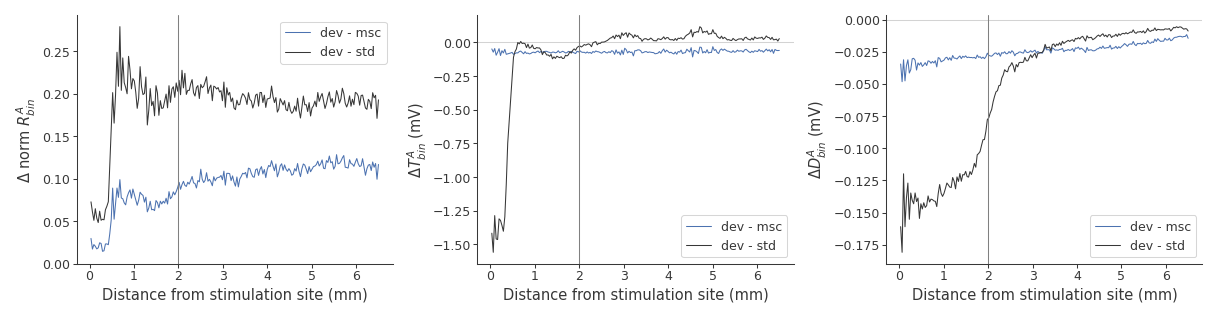

In [18]:
def panel_frac_diff_lines(ax, kind):
    raw = {'hist': disthist, 'TA': fine_TA, 'STD': fine_STD}
    assert kind in raw
    divisor = {'hist': disthist_initial, 'TA': mV, 'STD': 1}[kind]
    for cond in ('msc', 'std'):
        ax.plot(
            histedges[1:],
            (np.nanmean(raw[kind]['dev'][:, 1:], (0,1)) - np.nanmean(raw[kind][cond][:, 1:], (0,1))) / divisor,
            color=pu.colors[cond], label=f'dev - {cond}')
    if kind == 'hist':
        ax.set_ylim(bottom=0)
    else:
        ax.axhline(0, color='lightgrey', zorder=0)
    for edge in histedges_rough[1:-1]:
        ax.axvline(edge, color='grey')
    ax.set_xlabel('Distance from stimulation site (mm)')
    ax.set_ylabel({
        'hist': '$\\Delta$ norm $R^A_{bin}$',
        'TA': '$\\Delta T^A_{bin}$ (mV)',
        'STD': '$\\Delta D^A_{bin}$ (mV)'}
        [kind])
    ax.legend()
    sns.despine(ax=ax)

fig, axs = plt.subplots(1,3, figsize=(8,2), dpi=150, layout='constrained')
fig.patch.set_facecolor('w')
for ax, kind in zip(axs, ('hist', 'TA', 'STD')):
    panel_frac_diff_lines(ax, kind)

0.0~2.0 mm: 226.8 +- 13.2 neurons
2.0~6.5 mm: 773.2 +- 13.2 neurons
local TA dev < std: T = 482, p = 8.31e-17
local TA dev < msc: T = 831, p = 1.15e-13
global TA dev < msc: T = 1.09e+03, p = 1.37e-11

0.0~2.0 mm: 226.8 +- 13.2 neurons
2.0~6.5 mm: 773.2 +- 13.2 neurons
local STD dev < std: T = 735, p = 1.71e-14
local STD dev < msc: T = 1.46e+03, p = 6.13e-09
global STD dev < msc: T = 927, p = 7.27e-13



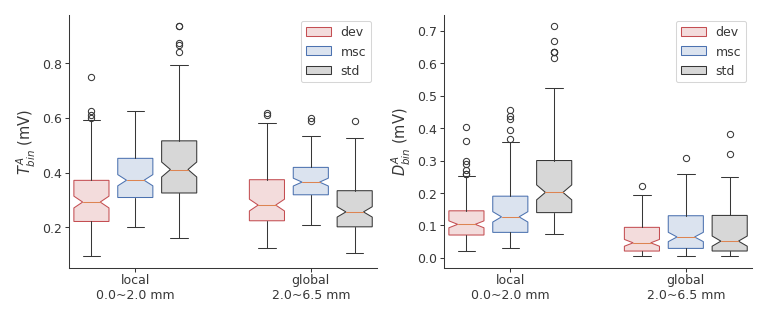

In [19]:
def panel_frac_rough_boxes(ax, kind):
    raw = {'hist': distrough, 'TA': rough_TA, 'STD': rough_STD}
    assert kind in raw
    divisor = {'hist': distrough_initial, 'TA': mV, 'STD': 1}[kind]
    rough = {cond: np.nanmean(raw[kind][cond][:, 1:], 1) / divisor for cond in conds}
    for i, cond in enumerate(conds):
        patchprops = {'color': pu.colors[cond], 'facecolor': pu.alpha_to_color(pu.colors[cond], .2)}
        ax.boxplot(
            rough[cond], notch=True, positions=np.arange(distbins_rough) + i/4, widths=.2,
            patch_artist=True, boxprops=patchprops, manage_ticks=False)
        ax.fill_between([],[],[], **patchprops, label=cond)
    if distbins_rough == 2:
        words = ('local', 'global')
        ax.set_xticks(
            np.arange(distbins_rough) + 1/4,
            [f'{words[i]}\n{histedges_rough[i]:.1f}~{histedges_rough[i+1]:.1f} mm'
            for i in range(distbins_rough)])
    else:
        ax.set_xticks(
            np.arange(distbins_rough) + 1/4,
            [f'{histedges_rough[i]:.1f}~{histedges_rough[i+1]:.1f} mm'
            for i in range(distbins_rough)])
    ax.set_ylabel({
        'hist': 'Norm $R^A_{bin}$',
        'TA': '$T^A_{bin}$ (mV)',
        'STD': '$D^A_{bin}$ (mV)'}
        [kind])
    ax.legend()
    sns.despine(ax=ax)

    for i in range(distbins_rough):
        print(f'{histedges_rough[i]:.1f}~{histedges_rough[i+1]:.1f} mm: '
              f'{roughbase.mean(0)[i]:.1f} +- {roughbase.std(0)[i]:.1f} neurons')
    
    if kind == 'hist':
        for cond in ('msc', 'std'):
            test = stats.wilcoxon(
                rough['dev'][:, 0] - rough[cond][:, 0],
                rough['dev'][:, 1] - rough[cond][:, 1],
                alternative='less'
            )
            print(f'R dev-{cond} local < global: T = {test.statistic:.3g}, p = {test.pvalue:.3g}')
    else:
        test = stats.wilcoxon(rough['dev'][:, 0], rough['std'][:, 0], alternative='less')
        print(f'local {kind} dev < std: T = {test.statistic:.3g}, p = {test.pvalue:.3g}')

        test = stats.wilcoxon(rough['dev'][:, 0], rough['msc'][:, 0], alternative='less')
        print(f'local {kind} dev < msc: T = {test.statistic:.3g}, p = {test.pvalue:.3g}')

        test = stats.wilcoxon(rough['dev'][:, 1], rough['msc'][:, 1], alternative='less')
        print(f'global {kind} dev < msc: T = {test.statistic:.3g}, p = {test.pvalue:.3g}')
    print()

fig, axs = plt.subplots(1,2, figsize=(5,2), dpi=150, layout='constrained')
fig.patch.set_facecolor('w')
for ax, kind in zip(axs, ('TA', 'STD')):
    panel_frac_rough_boxes(ax, kind)


0.0~2.0 mm: 226.8 +- 13.2 neurons
2.0~6.5 mm: 773.2 +- 13.2 neurons
local TA dev < std: T = 482, p = 8.31e-17
local TA dev < msc: T = 831, p = 1.15e-13
global TA dev < msc: T = 1.09e+03, p = 1.37e-11

0.0~2.0 mm: 226.8 +- 13.2 neurons
2.0~6.5 mm: 773.2 +- 13.2 neurons
local STD dev < std: T = 735, p = 1.71e-14
local STD dev < msc: T = 1.46e+03, p = 6.13e-09
global STD dev < msc: T = 927, p = 7.27e-13



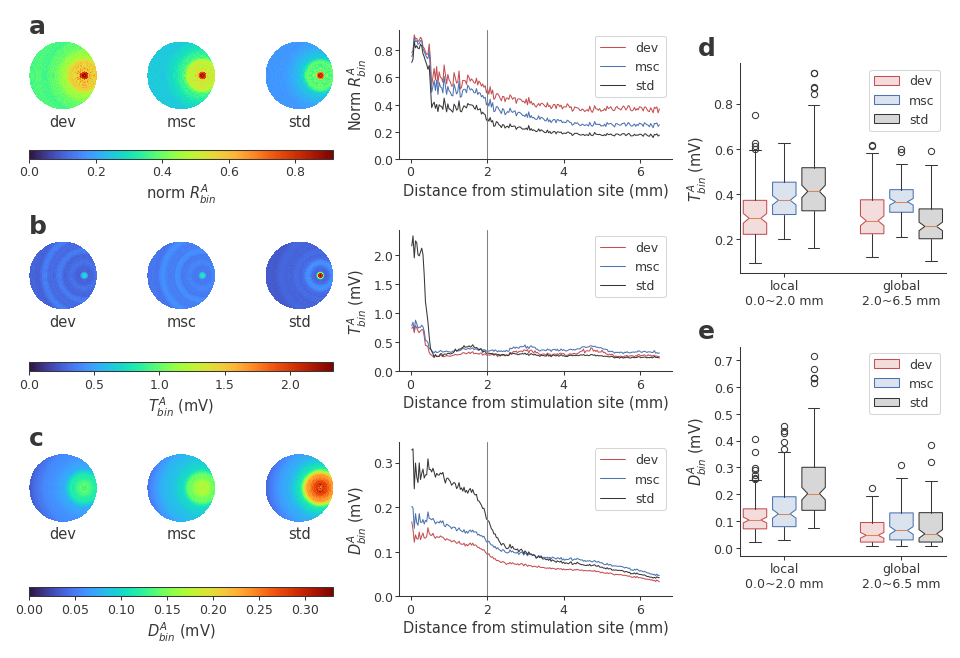

In [41]:
fig = plt.figure(figsize=(6.29, 4.25), layout='compressed', dpi=150)
gs_top = fig.add_gridspec(6, 5, width_ratios=(1,1,1,4,4), height_ratios=(10,1,10,1,10,1))

for row, kind in enumerate(('hist', 'TA', 'STD')):
    axs = [fig.add_subplot(gs_top[2*row, i]) for i in range(3)]
    cax = fig.add_subplot(gs_top[2*row+1, :3])
    panel_frac_space(axs, cax, kind, orientation='horizontal')
    for ax, cond in zip(axs, conds):
        ax.set_xlabel(cond)
    
    if kind == 'hist':
        panel_frac_hist_lines(fig.add_subplot(gs_top[2*row:2*(row+1), 3]))
    else:
        panel_raw_lines(fig.add_subplot(gs_top[2*row:2*(row+1), 3]), kind)
    
    pu.label_panel(axs[0], row)

subfig_right = fig.add_subfigure(gs_top[:, 4])
gs_right = subfig_right.add_gridspec(2)
for row, kind in enumerate(('TA', 'STD')):
    ax = subfig_right.add_subplot(gs_right[row])
    panel_frac_rough_boxes(ax, kind)
    pu.label_panel(ax, row+3)

plt.savefig('paper-1/fig10.pdf')